<a href="https://colab.research.google.com/github/Jubayer934/Sign_language_Detection/blob/main/ViVit_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✅ Step 1: Install Required Libraries

In [ ]:
pip install transformers datasets accelerate timm decord

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 78.1 MB/s eta 0:00:00


✅ Step 2: Load Pretrained ViViT Model + Feature Extractor

In [ ]:
from transformers import VideoMAEFeatureExtractor, VideoMAEForVideoClassification

# Load feature extractor and pretrained model
feature_extractor = VideoMAEFeatureExtractor.from_pretrained("MCG-NJU/videomae-base-finetuned-kinetics")
model = VideoMAEForVideoClassification.from_pretrained("MCG-NJU/videomae-base-finetuned-kinetics")

#  Prepares (resizes, normalizes) video frames for the model.
# This is the pretrained ViViT model, already trained on the Kinetics-400 dataset.

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/videomae/feature_extraction_videomae.py:30: FutureWarning: The class VideoMAEFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use VideoMAEImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/22.9k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

 Load the Dataset

What frame size the model expects (e.g., 224×224) <br>
How many frames (e.g., 16 frames from a video) <br>
What kind of normalization/scaling to apply

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

# Path to the zip file in Drive
zip_path = "/content/drive/MyDrive/ModelTrain/signlanguage/dataset/sign.zip"

# Unzip it to /content/
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/sign_dataset")

# Set dataset path
dataset_path = "/content/sign_dataset"

In [ ]:
import os

# List top-level files/folders
print(os.listdir("/content/sign_dataset"))

# If it's nested, explore further:
for root, dirs, files in os.walk("/content/sign_dataset"):
    print("Root:", root)
    print("Dirs:", dirs)
    print("Files:", files[:5])  # just print the first 5 files
    print("===")

['Answer', 'Elephant', 'cold', 'Duck', 'All of you', 'cut off', 'Follow', 'Fear', 'forget', 'Dog', 'Everyone', 'Everyday', 'Ask', 'feel hot', 'forgive', 'Collectin', 'Feelings', 'Another', 'Chicken', 'come', 'brother', 'Fast', 'Cow', 'Difficalty', 'Cat', 'Around', 'Carefully', 'Crow', 'A lot', 'Crocodile']
Root: /content/sign_dataset
Dirs: ['Answer', 'Elephant', 'cold', 'Duck', 'All of you', 'cut off', 'Follow', 'Fear', 'forget', 'Dog', 'Everyone', 'Everyday', 'Ask', 'feel hot', 'forgive', 'Collectin', 'Feelings', 'Another', 'Chicken', 'come', 'brother', 'Fast', 'Cow', 'Difficalty', 'Cat', 'Around', 'Carefully', 'Crow', 'A lot', 'Crocodile']
Files: []
===
Root: /content/sign_dataset/Answer
Dirs: []
Files: ['s_34_w_124_a_30.mp4', 's_52_w_124_a_30.mp4', 's_14_w_124_a_30.mp4', 's_47_w_124_a_30.mp4', 's_40_w_124_a_30.mp4']
===
Root: /content/sign_dataset/Elephant
Dirs: []
Files: ['s_51_w_65_s_90.mp4', 's_35_w_065_a_90.mp4', 's_26_w_65_s_90.mp4', 's_39_w_065_a_90.mp4', 's_34_w_065_a_90.mp4'

Step 3: Prepare Your Dataset List


In [ ]:
import os

def get_video_paths_labels(root_dir):
    video_paths = []
    labels = []
    class_names = sorted(os.listdir(root_dir))
    label_map = {name: i for i, name in enumerate(class_names)}

    for cls in class_names:
        cls_folder = os.path.join(root_dir, cls)
        for fname in os.listdir(cls_folder):
            if fname.endswith('.mp4'):
                video_paths.append(os.path.join(cls_folder, fname))
                labels.append(label_map[cls])
    return video_paths, labels, label_map

video_paths, labels, label_map = get_video_paths_labels("/content/sign_dataset")

Step 4: Split Dataset Into Train & Validation

In [ ]:
from sklearn.model_selection import train_test_split

train_paths, val_paths, train_labels, val_labels = train_test_split(
    video_paths, labels, test_size=0.25, stratify=labels, random_state=42
)


Step 5: Create Dataset Class

In [ ]:
from torch.utils.data import Dataset
from decord import VideoReader, cpu
import numpy as np

class SignLanguageDataset(Dataset):
    def __init__(self, video_paths, labels, feature_extractor, num_frames=16):
        self.video_paths = video_paths
        self.labels = labels
        self.feature_extractor = feature_extractor
        self.num_frames = num_frames

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        vr = VideoReader(self.video_paths[idx], ctx=cpu(0))
        total_frames = len(vr)
        indices = np.linspace(0, total_frames-1, min(self.num_frames, total_frames)).astype(int)
        frames = vr.get_batch(indices).asnumpy()
        inputs = self.feature_extractor(list(frames), return_tensors="pt")
        return inputs["pixel_values"].squeeze(0), self.labels[idx]

Step 6: Create DataLoaders

In [ ]:
from torch.utils.data import DataLoader

train_dataset = SignLanguageDataset(train_paths, train_labels, feature_extractor)
val_dataset = SignLanguageDataset(val_paths, val_labels, feature_extractor)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=2)

In [ ]:
for i, (pixel_values, labels) in enumerate(train_loader):
    print(f"Batch {i+1}")
    print("Pixel values shape:", pixel_values.shape)  # Should be (B, T, C, H, W) or (B, 3, 16, 224, 224) after permute
    print("Labels:", labels)
    if i == 1:  # print only first 2 batches
        break


Batch 1
Pixel values shape: torch.Size([2, 16, 3, 224, 224])
Labels: tensor([21, 19])
Batch 2
Pixel values shape: torch.Size([2, 16, 3, 224, 224])
Labels: tensor([28, 13])


In [ ]:
for i, (pixel_values, labels) in enumerate(val_loader):
    print(f"Validation Batch {i+1}")
    print("Pixel values shape:", pixel_values.shape)
    print("Labels:", labels)
    if i == 1:
        break


Validation Batch 1
Pixel values shape: torch.Size([2, 16, 3, 224, 224])
Labels: tensor([20,  5])
Validation Batch 2
Pixel values shape: torch.Size([2, 16, 3, 224, 224])
Labels: tensor([12, 28])


In [ ]:
for label_idx in labels:
    for class_name, idx in label_map.items():
        if idx == label_idx.item():
            print(f"Label {label_idx.item()} corresponds to class: {class_name}")

Label 12 corresponds to class: Crow
Label 28 corresponds to class: forget


In [ ]:
# From (B, T, C, H, W) to (B, C, T, H, W)

for pixel_values, labels in train_loader:
    print("Before permute:", pixel_values.shape)
    pixel_values = pixel_values.permute(0, 2, 1, 3, 4)
    print("After permute:", pixel_values.shape)
    break

Before permute: torch.Size([2, 16, 3, 224, 224])
After permute: torch.Size([2, 3, 16, 224, 224])


In [ ]:
print(pixel_values.shape)

torch.Size([2, 3, 16, 224, 224])


In [ ]:
print(f"Number of training videos: {len(train_dataset)}")
print(f"Number of validation videos: {len(val_dataset)}")

Number of training videos: 248
Number of validation videos: 83


In [ ]:
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")

Number of training batches: 124
Number of validation batches: 42


In [ ]:
print(f"Number of classes: {len(label_map)}")

Number of classes: 30


In [ ]:
print(f"Label map: {label_map}")

Label map: {'A lot': 0, 'All of you': 1, 'Another': 2, 'Answer': 3, 'Around': 4, 'Ask': 5, 'Carefully': 6, 'Cat': 7, 'Chicken': 8, 'Collectin': 9, 'Cow': 10, 'Crocodile': 11, 'Crow': 12, 'Difficalty': 13, 'Dog': 14, 'Duck': 15, 'Elephant': 16, 'Everyday': 17, 'Everyone': 18, 'Fast': 19, 'Fear': 20, 'Feelings': 21, 'Follow': 22, 'brother': 23, 'cold': 24, 'come': 25, 'cut off': 26, 'feel hot': 27, 'forget': 28, 'forgive': 29}


Step 7: Adjust Model Output Layer

In [ ]:
import torch.nn as nn

num_classes = len(label_map)
model.classifier = nn.Linear(model.classifier.in_features, num_classes)
model.config.num_labels = num_classes

Step 8: Training Loop with Validation & Best Model Saving

In [ ]:
import torch
import torch.nn as nn
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, classification_report

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"✅ Using device: {device}")

# Set loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=5e-5)

# Save path for best model
best_val_loss = float('inf')
save_path = "/content/drive/MyDrive/ModelTrain/signlanguage/Model/vivit_best_model.pth"

# Reverse label_map for readable class names
idx_to_class = {v: k for k, v in label_map.items()}

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    print(f"\n🎯 Epoch {epoch + 1}/{num_epochs}")
    model.train()
    train_loss = 0

    for pixel_values, labels in train_loader:
        pixel_values = pixel_values.to(device)
        labels = labels.to(device)

        outputs = model(pixel_values=pixel_values)
        loss = criterion(outputs.logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0
    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for pixel_values, labels in val_loader:
            pixel_values = pixel_values.to(device)
            labels = labels.to(device)

            outputs = model(pixel_values=pixel_values)
            loss = criterion(outputs.logits, labels)
            val_loss += loss.item()

            preds = torch.argmax(outputs.logits, dim=1)
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_acc = accuracy_score(true_labels, pred_labels)

    print(f"📉 Train Loss: {avg_train_loss:.4f} | 📈 Val Loss: {avg_val_loss:.4f} | ✅ Val Acc: {val_acc*100:.2f}%")

    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), save_path)
        print(f"💾 Best model saved with val loss {best_val_loss:.4f} to {save_path}")

    # Optional: Detailed classification report every epoch
    print("\n🧾 Classification Report:")
    print(classification_report(
        [idx_to_class[i] for i in true_labels],
        [idx_to_class[i] for i in pred_labels],
        digits=3
    ))

✅ Using device: cuda

🎯 Epoch 1/10
📉 Train Loss: 2.6957 | 📈 Val Loss: 1.9681 | ✅ Val Acc: 49.40%
💾 Best model saved with val loss 1.9681 to /content/drive/MyDrive/ModelTrain/signlanguage/Model/vivit_best_model.pth

🧾 Classification Report:
              precision    recall  f1-score   support

       A lot      0.375     1.000     0.545         3
  All of you      0.000     0.000     0.000         2
     Another      0.000     0.000     0.000         3
      Answer      0.000     0.000     0.000         3
      Around      0.000     0.000     0.000         2
         Ask      1.000     0.333     0.500         3
   Carefully      1.000     0.333     0.500         3
         Cat      0.750     1.000     0.857         3
     Chicken      0.250     0.333     0.286         3
   Collectin      0.286     1.000     0.444         2
         Cow      1.000     1.000     1.000         3
   Crocodile      0.667     1.000     0.800         2
        Crow      0.600     1.000     0.750         3
  D

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


📉 Train Loss: 1.1693 | 📈 Val Loss: 1.1993 | ✅ Val Acc: 72.29%
💾 Best model saved with val loss 1.1993 to /content/drive/MyDrive/ModelTrain/signlanguage/Model/vivit_best_model.pth

🧾 Classification Report:
              precision    recall  f1-score   support

       A lot      1.000     1.000     1.000         3
  All of you      0.667     1.000     0.800         2
     Another      0.333     0.333     0.333         3
      Answer      0.667     0.667     0.667         3
      Around      0.000     0.000     0.000         2
         Ask      1.000     0.667     0.800         3
   Carefully      1.000     1.000     1.000         3
         Cat      1.000     1.000     1.000         3
     Chicken      1.000     0.333     0.500         3
   Collectin      0.500     0.500     0.500         2
         Cow      0.750     1.000     0.857         3
   Crocodile      0.667     1.000     0.800         2
        Crow      0.600     1.000     0.750         3
  Difficalty      0.333     0.333     

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Load the best Model

In [ ]:
best_model = "/content/drive/MyDrive/ModelTrain/signlanguage/Model/vivit_best_model.pth"

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
import torch.nn as nn

def evaluate(model, dataloader, label_map, device):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    val_loss = 0
    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for pixel_values, labels in dataloader:
            pixel_values = pixel_values.to(device)
            labels = labels.to(device)

            outputs = model(pixel_values=pixel_values)
            loss = criterion(outputs.logits, labels)
            val_loss += loss.item()

            preds = torch.argmax(outputs.logits, dim=1)
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())

    avg_loss = val_loss / len(dataloader)
    accuracy = accuracy_score(true_labels, pred_labels)

    # Optional classification report (can print later)
    report = classification_report(
        [list(label_map.keys())[list(label_map.values()).index(i)] for i in true_labels],
        [list(label_map.keys())[list(label_map.values()).index(i)] for i in pred_labels],
        digits=3
    )

    return avg_loss, accuracy, report

In [ ]:
# Load the best model
model.load_state_dict(torch.load(best_model))
model.eval()

# Run evaluation
avg_test_loss, test_acc, _ = evaluate(model, val_loader, label_map, device)

# Generate predictions for confusion matrix
true_labels = []
pred_labels = []

with torch.no_grad():
    for pixel_values, labels in val_loader:
        pixel_values = pixel_values.to(device)
        labels = labels.to(device)
        outputs = model(pixel_values=pixel_values)
        preds = torch.argmax(outputs.logits, dim=1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

idx_to_class = {v: k for k, v in label_map.items()}
true_class_names = [idx_to_class[i] for i in true_labels]
pred_class_names = [idx_to_class[i] for i in pred_labels]

cm = confusion_matrix(true_class_names, pred_class_names, labels=list(idx_to_class.values()))
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=idx_to_class.values(),
            yticklabels=idx_to_class.values(),
            cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Make sure num_classes is still set correctly
model.classifier = nn.Linear(model.classifier.in_features, num_classes)
model.load_state_dict(torch.load(best_model))
model.eval()
model.to(device)

VideoMAEForVideoClassification(
  (videomae): VideoMAEModel(
    (embeddings): VideoMAEEmbeddings(
      (patch_embeddings): VideoMAEPatchEmbeddings(
        (projection): Conv3d(3, 768, kernel_size=(2, 16, 16), stride=(2, 16, 16))
      )
    )
    (encoder): VideoMAEEncoder(
      (layer): ModuleList(
        (0-11): 12 x VideoMAELayer(
          (attention): VideoMAEAttention(
            (attention): VideoMAESelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
            )
            (output): VideoMAESelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): VideoMAEIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
    

In [ ]:
def predict_video(video_path, model, feature_extractor, label_map, num_frames=16):
    # Load video frames
    vr = VideoReader(video_path, ctx=cpu(0))
    total_frames = len(vr)
    indices = np.linspace(0, total_frames - 1, min(num_frames, total_frames)).astype(int)
    frames = vr.get_batch(indices).asnumpy()

    # Preprocess
    inputs = feature_extractor(list(frames), return_tensors="pt")
    pixel_values = inputs["pixel_values"].to(device)

    # Inference
    with torch.no_grad():
        outputs = model(pixel_values)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1)
        pred_class_idx = torch.argmax(probs, dim=1).item()

    # Map index to class name
    class_name = [k for k, v in label_map.items() if v == pred_class_idx][0]
    confidence = probs[0][pred_class_idx].item()
    return class_name, confidence

In [ ]:
video_path = "/content/sign_dataset/sign_dataset/Ask/s_34_w_043_a_30.mp4"  # <-- change this to your actual file
pred_class, confidence = predict_video(video_path, model, feature_extractor, label_map)
print(f"Predicted: {pred_class} ({confidence*100:.1f}%)")

Predicted: Ask (99.6%)


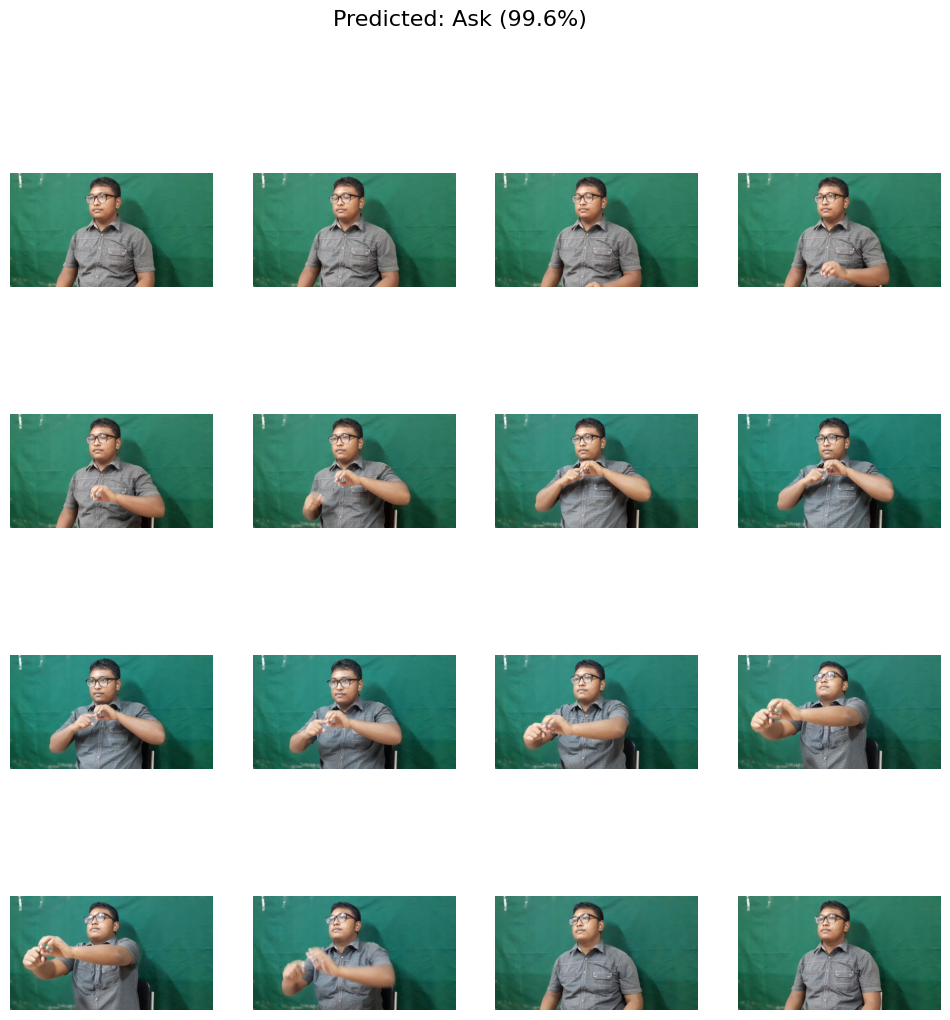

In [ ]:
vr = VideoReader(video_path, ctx=cpu(0))
frames = vr.get_batch(np.linspace(0, len(vr)-1, 16).astype(int)).asnumpy()

import matplotlib.pyplot as plt

fig, axs = plt.subplots(4, 4, figsize=(12, 12))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(frames[i])
    ax.axis('off')
plt.suptitle(f"Predicted: {pred_class} ({confidence*100:.1f}%)", fontsize=16)
plt.show()

Check Every Video

In [ ]:
import os
from decord import VideoReader, cpu
import numpy as np
import torch.nn.functional as F

def predict_video(video_path, model, feature_extractor, label_map, num_frames=16):
    vr = VideoReader(video_path, ctx=cpu(0))
    total_frames = len(vr)
    indices = np.linspace(0, total_frames - 1, min(num_frames, total_frames)).astype(int)
    frames = vr.get_batch(indices).asnumpy()
    inputs = feature_extractor(list(frames), return_tensors="pt")
    pixel_values = inputs["pixel_values"].to(device)

    with torch.no_grad():
        outputs = model(pixel_values)
        probs = F.softmax(outputs.logits, dim=1)
        pred_idx = torch.argmax(probs, dim=1).item()
        confidence = probs[0][pred_idx].item()

    pred_class = [k for k, v in label_map.items() if v == pred_idx][0]
    return pred_class, confidence

In [ ]:
dataset_root = "/content/sign_dataset/sign_dataset"  # Change this to your dataset folder

for class_folder in os.listdir(dataset_root):
    folder_path = os.path.join(dataset_root, class_folder)
    if not os.path.isdir(folder_path):
        continue  # Skip non-folder files

    print(f"\n📂 Class folder: {class_folder}")

    for video_file in os.listdir(folder_path):
        if not video_file.endswith(".mp4"):
            continue
        video_path = os.path.join(folder_path, video_file)
        try:
            pred_class, confidence = predict_video(video_path, model, feature_extractor, label_map)
            print(f"📹 {video_file} → Predicted: {pred_class} ({confidence*100:.1f}%)")
        except Exception as e:
            print(f"⚠️ Failed on {video_file}: {e}")


📂 Class folder: Another
📹 s_47_w_083_a_30.mp4 → Predicted: Another (80.5%)
📹 s_46_w_083_a_30.mp4 → Predicted: Another (92.4%)
📹 s_45_w_083_a_30.mp4 → Predicted: Another (99.3%)
📹 s_35_w_083_a_30.mp4 → Predicted: Another (99.3%)
📹 s_49_w_083_a_30.mp4 → Predicted: brother (48.8%)
📹 s_34_w_083_a_30.mp4 → Predicted: Another (91.9%)
📹 s_43_w_083_a_30.mp4 → Predicted: Another (99.5%)
📹 s_41_w_083_a_30.mp4 → Predicted: Another (99.4%)
📹 s_54_w_083_a_30.mp4 → Predicted: Another (99.5%)
📹 s_42_w_083_a_30.mp4 → Predicted: Another (99.4%)
📹 s_40_w_083_a_30.mp4 → Predicted: Another (99.3%)
📹 s_44_w_083_a_30.mp4 → Predicted: Another (99.5%)

📂 Class folder: All_of_you
📹 s_54_w_104_a_30.mp4 → Predicted: All_of_you (99.4%)
📹 s_52_w_104_a_30.mp4 → Predicted: All_of_you (99.4%)
📹 s_41_w_104_a_30.mp4 → Predicted: All_of_you (89.7%)
📹 s_34_w_104_a_30.mp4 → Predicted: All_of_you (99.3%)
📹 s_53_w_104_a_30.mp4 → Predicted: All_of_you (99.4%)
📹 s_14_w_104_a_30.mp4 → Predicted: All_of_you (99.3%)
📹 s_47_w_10